# Handling imbalanced data in customer churn prediction

Dataset: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

In [70]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

## Data Ingestion

In [71]:
df = pd.read_csv("../08-customer_churn_pred\WA_Fn-UseC_-Telco-Customer-Churn.csv")
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


## EDA

dropping 'customerID' -> no use

In [72]:
df.drop('customerID', axis='columns', inplace=True)

In [73]:
df1 = df[df.TotalCharges != ' ']

df1 = df1.copy()

df1.TotalCharges = pd.to_numeric(df1.TotalCharges, errors='coerce')
df1.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

## Data Visualization

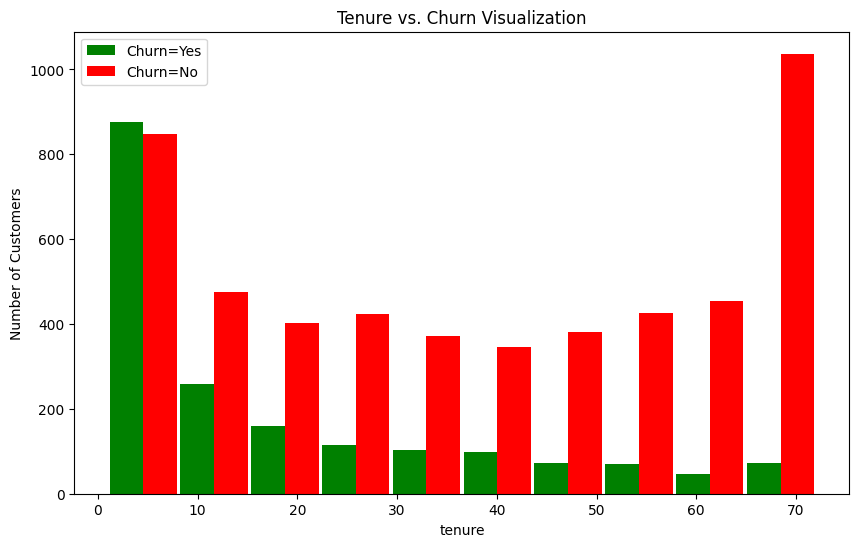

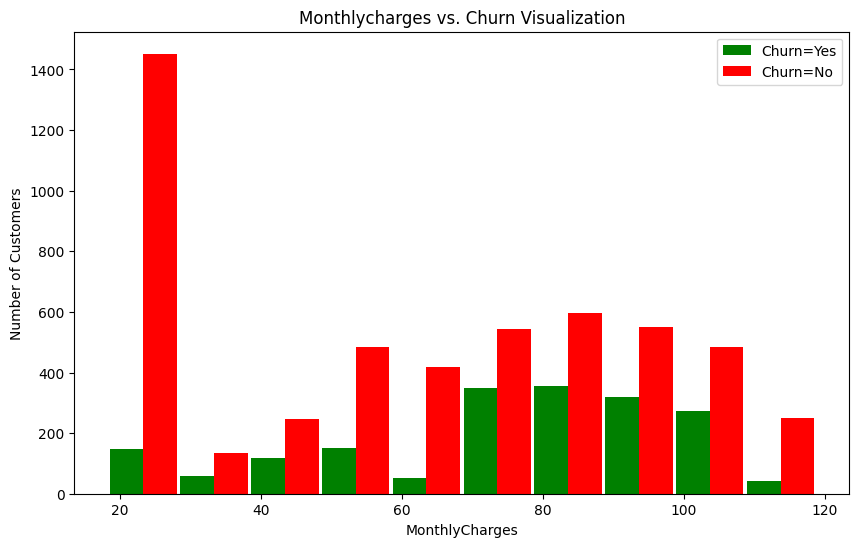

In [74]:
def plot_churn_distribution(df, target_column, feature_column, labels=('Yes', 'No'), colors=('green', 'red')):
    # Separating the data based on the target column
    feature_churn_yes = df[df[target_column] == labels[0]][feature_column]
    feature_churn_no = df[df[target_column] == labels[1]][feature_column]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.xlabel(feature_column)
    plt.ylabel("Number of Customers")
    plt.title(f"{feature_column.capitalize()} vs. {target_column.capitalize()} Visualization")

    # Plot histogram
    plt.hist([feature_churn_yes, feature_churn_no], rwidth=0.95, color=colors, label=[f"{target_column}={labels[0]}", f"{target_column}={labels[1]}"])
    plt.legend()
    plt.show()

plot_churn_distribution(df1, target_column='Churn', feature_column='tenure')
plot_churn_distribution(df1, target_column='Churn', feature_column='MonthlyCharges')

## Data Pre-Processing

### Encoding

In [75]:
def print_unique_col_values(df):
    for column in df:
        if df[column].dtypes=='object':
            print(f'{column}: {df[column].unique()}')

print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


In [76]:
df2 = df1.copy()

df2.replace('No internet service', 'No', inplace=True)
df2.replace('No phone service', 'No', inplace=True)

print_unique_col_values(df2)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


In [77]:
yes_no_columns = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']

for col in yes_no_columns:
    df2[col] = df2[col].replace({'Yes': 1, 'No': 0})

C:\Users\Hp\AppData\Local\Temp\ipykernel_16156\2863004318.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2[col] = df2[col].replace({'Yes': 1, 'No': 0})


In [78]:
def print_unique_col(df):
    for column in df:
        print(f'{column}: {df[column].unique()}')

print_unique_col(df2)

gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService: [0 1]
MultipleLines: [0 1]
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [0 1]
StreamingTV: [0 1]
StreamingMovies: [0 1]
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: [1 0]
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn: [0 1]


In [79]:
df2['gender'] = df2['gender'].replace({'Female': 1, 'Male': 0})
print(df2.gender.unique())

df3 = pd.get_dummies(data = df2, columns = ['InternetService', 'Contract', 'PaymentMethod'])
df3.columns

[1 0]


C:\Users\Hp\AppData\Local\Temp\ipykernel_16156\1491869111.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['gender'] = df2['gender'].replace({'Female': 1, 'Male': 0})


Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [80]:
df3

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,True,False,False,True,False,False,False,False,True,False
1,0,0,0,0,34,1,0,1,0,1,...,True,False,False,False,True,False,False,False,False,True
2,0,0,0,0,2,1,0,1,1,0,...,True,False,False,True,False,False,False,False,False,True
3,0,0,0,0,45,0,0,1,0,1,...,True,False,False,False,True,False,True,False,False,False
4,1,0,0,0,2,1,0,0,0,0,...,False,True,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,1,1,24,1,1,1,0,1,...,True,False,False,False,True,False,False,False,False,True
7039,1,0,1,1,72,1,1,0,1,1,...,False,True,False,False,True,False,False,True,False,False
7040,1,0,1,1,11,0,0,1,0,0,...,True,False,False,True,False,False,False,False,True,False
7041,0,1,1,0,4,1,1,0,0,0,...,False,True,False,True,False,False,False,False,False,True


In [81]:
boolean_cols = ['InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 
                'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 
                'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

# Convert boolean columns to integer (1 for True, 0 for False)
for col in boolean_cols:
    df3[col] = df3[col].astype(int)

### Scaling

In [82]:
scaler = MinMaxScaler()

cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

df3[cols_to_scale] = scaler.fit_transform(df3[cols_to_scale])

print_unique_col(df3)

gender: [1 0]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService: [0 1]
MultipleLines: [0 1]
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [

### Train Test Split

In [83]:
X = df3.drop('Churn', axis='columns')
y = df3['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

print(X_train.shape)
print(X_test.shape)

(5625, 26)
(1407, 26)


## Model

In [84]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report: \n", classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       999
           1       0.67      0.55      0.61       408

    accuracy                           0.79      1407
   macro avg       0.75      0.72      0.73      1407
weighted avg       0.79      0.79      0.79      1407



## Mitigating Skewdness of Data

ref: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

In [85]:
# Class count
count_class_0, count_class_1 = df3.Churn.value_counts()

# Divide by class
df_class_0 = df3[df3['Churn'] == 0]
df_class_1 = df3[df3['Churn'] == 1]

### Method 1: Undersampling

In [86]:
# Under-sample 0-class and concat the DataFrames of both class
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.Churn.value_counts())

X = df_test_under.drop('Churn', axis='columns')
y = df_test_under['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y) # stratify means to split the data in the same ratio as the original data

# Number of classes in training Data
y_train.value_counts()

Random under-sampling:
Churn
0    1869
1    1869
Name: count, dtype: int64


Churn
0    1495
1    1495
Name: count, dtype: int64

In [87]:
method_1 = LogisticRegression()
method_1.fit(X_train, y_train)

y_pred_under_sampling = method_1.predict(X_test)

print("Classification Report: \n", classification_report(y_test, y_pred_under_sampling))

Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.73      0.75       374
           1       0.74      0.77      0.76       374

    accuracy                           0.75       748
   macro avg       0.75      0.75      0.75       748
weighted avg       0.75      0.75      0.75       748



*  f1-score for minority class 1 improved from 0.61 to 0.76
*  score for class 0 reduced to 0.75 from 0.86 but that's ok

### Method 2: Oversampling

In [88]:
# Oversample 1-class and concat the DataFrames of both classes
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.Churn.value_counts())

X = df_test_over.drop('Churn',axis='columns')
y = df_test_over['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

# Number of classes in training & testing Data
print(y_train.value_counts())
print(y_test.value_counts())

Random over-sampling:
Churn
0    5163
1    5163
Name: count, dtype: int64
Churn
1    4130
0    4130
Name: count, dtype: int64
Churn
1    1033
0    1033
Name: count, dtype: int64


In [89]:
method_2 = LogisticRegression()
method_2.fit(X_train, y_train)

y_pred_over_sampling = method_2.predict(X_test)

print("Classification Report: \n", classification_report(y_test, y_pred_over_sampling))

Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.72      0.76      1033
           1       0.75      0.82      0.78      1033

    accuracy                           0.77      2066
   macro avg       0.78      0.77      0.77      2066
weighted avg       0.78      0.77      0.77      2066



*  f1-score for minority class 1 improved from 0.61 to 0.76
*  score for class 0 reduced to 0.78 from 0.86 but that's ok

### Method 3: SMOTE

(uses knn under the hood)

In [90]:
X = df3.drop('Churn', axis='columns')
y = df3['Churn']

In [91]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

print(y_sm.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)

# Number of classes in training Data
print(y_train.value_counts())

Churn
0    5163
1    5163
Name: count, dtype: int64
Churn
1    4130
0    4130
Name: count, dtype: int64


In [92]:
method_3 = LogisticRegression()
method_3.fit(X_train, y_train)

y_pred_smote = method_3.predict(X_test)

print("Classification Report: \n", classification_report(y_test, y_pred_smote))

Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.77      0.79      1033
           1       0.78      0.82      0.80      1033

    accuracy                           0.79      2066
   macro avg       0.79      0.79      0.79      2066
weighted avg       0.79      0.79      0.79      2066



*  f1-score for minority class 1 improved from 0.61 to 0.80
*  score for class 0 reduced to 0.79 from 0.86 but that's ok

### Method 4: Ensemble with undersampling

In [93]:
print(df3.Churn.value_counts())

# Regain Original features and labels
X = df3.drop('Churn',axis='columns')
y = df3['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

y_train.value_counts()

Churn
0    5163
1    1869
Name: count, dtype: int64


Churn
0    4130
1    1495
Name: count, dtype: int64

In [94]:
df4 = X_train.copy()
df4['Churn'] = y_train

df4_class0 = df4[df4.Churn == 0]
df4_class1 = df4[df4.Churn == 1]

def get_train_batch(df_majority, df_minority, start, end):
    df_train = pd.concat([df_majority[start:end], df_minority], axis=0)

    X_train = df_train.drop('Churn', axis='columns')
    y_train = df_train.Churn
    return X_train, y_train

**Ensemble (with 3 batches)**

model_1 -> class_1(1495) + class_0(0, 1495)

model_2 -> class_1(1495) + class_0(1495, 2990)

model_3 -> class_1(1495) + class_0(2990, 4130)

In [95]:
X_train, y_train = get_train_batch(df4_class0, df4_class1, 0, 1495)

method_4_1 = LogisticRegression()
method_4_1.fit(X_train, y_train)

y_pred_1 = method_4_1.predict(X_test)

print("Classification Report: \n", classification_report(y_test, y_pred_1))

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.73      0.81      1033
           1       0.52      0.79      0.62       374

    accuracy                           0.75      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.75      0.76      1407



In [96]:
X_train, y_train = get_train_batch(df4_class0, df4_class1, 1495, 2990)

method_4_2 = LogisticRegression()
method_4_2.fit(X_train, y_train)

y_pred_2 = method_4_2.predict(X_test)

print("Classification Report: \n", classification_report(y_test, y_pred_2))

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.72      0.80      1033
           1       0.50      0.79      0.62       374

    accuracy                           0.74      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.80      0.74      0.75      1407



In [97]:
X_train, y_train = get_train_batch(df4_class0, df4_class1, 2990, 4130)

method_4_3 = LogisticRegression()
method_4_3.fit(X_train, y_train)

y_pred_3 = method_4_3.predict(X_test)

print("Classification Report: \n", classification_report(y_test, y_pred_3))

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.64      0.76      1033
           1       0.46      0.83      0.59       374

    accuracy                           0.70      1407
   macro avg       0.69      0.74      0.67      1407
weighted avg       0.79      0.70      0.71      1407



**Combining those 3 individual models now**

In [98]:
y_pred_final = y_pred_1.copy()
for i in range(len(y_pred_1)):
    n_ones = y_pred_1[i] + y_pred_2[i] + y_pred_3[i]
    if n_ones>1:
        y_pred_final[i] = 1
    else:
        y_pred_final[i] = 0

cl_rep = classification_report(y_test, y_pred_final)
print(cl_rep)

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1033
           1       0.50      0.80      0.62       374

    accuracy                           0.73      1407
   macro avg       0.70      0.76      0.71      1407
weighted avg       0.80      0.73      0.75      1407

